<a href="https://colab.research.google.com/github/JaiderSantos/metodos1_JaiderSantos_NicolasGomez/blob/main/Parcial3/HiggsB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
!pip install emcee
!pip install corner
import emcee
import corner

In [2]:
# Cargar los datos
data = pd.read_csv("HiggsFitting.csv")
Masas = pd.DataFrame()
Masas['masas'] = data

In [3]:
Bines = np.linspace(100, 160, 31)
hist, edges = np.histogram(Masas['masas'], bins=Bines)

bin_centers = 0.5 * (edges[:-1] + edges[1:])
#_____________________________________
# Configuración de límites
bounds = [(0.1, 50)]  # Evitar divisiones por 0

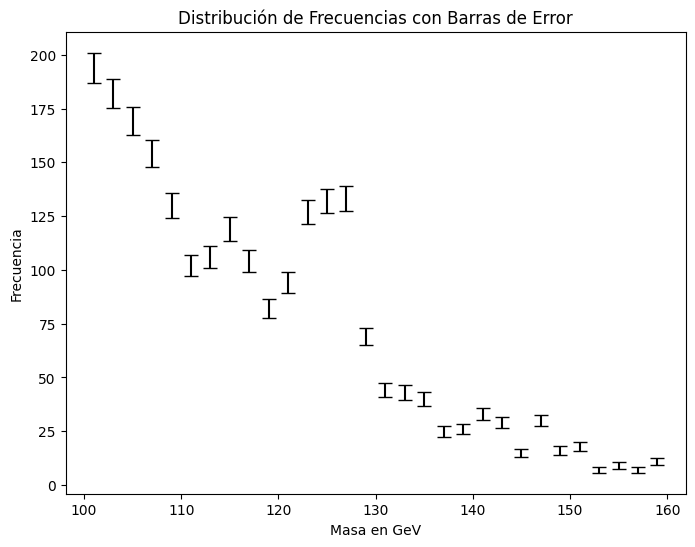

In [4]:
# Crear los bins y calcular el histograma
Bines = np.linspace(100, 160, 31)  # 30 bines entre 100 y 160 GeV
hist, edges = np.histogram(Masas['masas'], bins=Bines)

# Calcular los centros de los bines y las barras de error
bin_centers = 0.5 * (edges[:-1] + edges[1:])  # Centros de los bines


# Graficar
plt.figure(figsize=(8, 6))
plt.errorbar(bin_centers, hist, yerr=0.5 * np.sqrt(hist), fmt='none', ecolor='k', capsize=5)

# Configurar etiquetas y título
plt.xlabel("Masa en GeV")
plt.ylabel("Frecuencia")
plt.title("Distribución de Frecuencias con Barras de Error")

# Mostrar la gráfica
plt.show()

In [5]:
def neg_log_likelihood_alt(params, x):
    A, mu, sigma, alpha = params
    gauss = A * (1 / (np.sqrt(2 * np.pi) * sigma**2)) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    exp_bg = (1 - A) * (1 / alpha) * np.exp(-(x - 100) / alpha)
    likelihood = gauss + exp_bg
    return -np.sum(np.log(likelihood))
def neg_log_likelihood_null(alpha, x):#modelo negacionista
    likelihood = (1 / alpha) * np.exp(-(x - 100) / alpha)
    # Optimización
    return -np.sum(np.log(likelihood))

In [6]:
# Límites
bounds_alt = [(0, 1), (110, 150), (1, 20), (1, 50)]  # Ajuste de límites
# Optimización
initial_guess = [0.5, 125, 10, 10]
result_alt = minimize(neg_log_likelihood_alt, x0=initial_guess, args=(Masas['masas'],), bounds=bounds_alt)
A_opt, mu_opt, sigma_opt, alpha_opt_alt = result_alt.x

print(f"Mejor ajuste: A = {A_opt}, miu = {mu_opt}, sigma = {sigma_opt}, alpha = {alpha_opt_alt}")


Mejor ajuste: A = 0.07372754715147692, miu = 125.9947059465909, sigma = 1.0, alpha = 16.95222202996295


In [7]:
x = np.linspace(100, 160, 1000)
result = minimize(neg_log_likelihood_null, x0=[10], args=(Masas['masas'],), bounds=bounds)
alpha_opt = result.x[0]
print(f"Mejor ajuste: alpha = {alpha_opt}")


Mejor ajuste: alpha = 17.61888053628762


In [8]:
hbar = 6.582e-25  # GeV·s
tau = hbar / sigma_opt
print(f"Tiempo de vida: {tau} s")

Tiempo de vida: 6.582e-25 s


In [9]:
model_null = (1 / alpha_opt) * np.exp(-(x - 100) / alpha_opt)
alt_model = A_opt * (1 / (np.sqrt(2 * np.pi) * sigma_opt**2)) * np.exp(-0.5 * ((x - mu_opt) / sigma_opt)**2) + (1 - A_opt) * (1 / alpha_opt_alt) * np.exp(-(x - 100) / alpha_opt_alt)


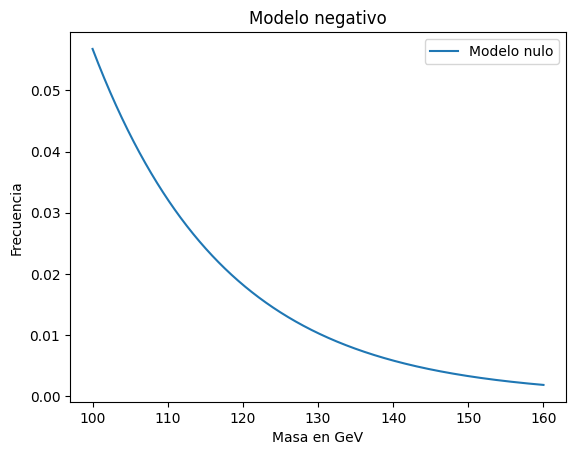

In [10]:
plt.plot(x, model_null, label='Modelo nulo')
plt.xlabel("Masa en GeV")
plt.ylabel("Frecuencia")
plt.title("Modelo negativo")
plt.legend()
plt.show()

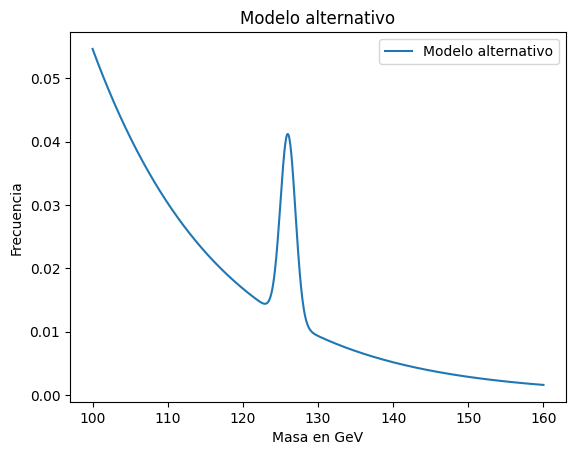

In [11]:
plt.plot(x, alt_model, label='Modelo alternativo')
plt.xlabel("Masa en GeV")
plt.ylabel("Frecuencia")
plt.title("Modelo alternativo")
plt.legend()
plt.show()

In [12]:
#se hacen las negaciones
L_null = neg_log_likelihood_null(alpha_opt, Masas['masas'])
L_alt = neg_log_likelihood_alt(result_alt.x, Masas['masas'])
n_sigma = np.sqrt(-2 * (L_alt - L_null))
print(f"Desviaciones estándar (nσ): {n_sigma}")

Desviaciones estándar (nσ): 12.688796555411207


In [13]:
def LogPrior(p):
  A, mu, sigma, alpha = p
  if 0. < A < 1. and 100. <= mu <= 300. and 0.1 <= sigma <= 20. and 1 <= alpha <= 50:
    return 0.
  else:
    return -np.inf
def log_likelihood(params, x):
    return -neg_log_likelihood_alt(params, x)

def log_posterior(params, x):
    prior = LogPrior(params)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(params, x)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


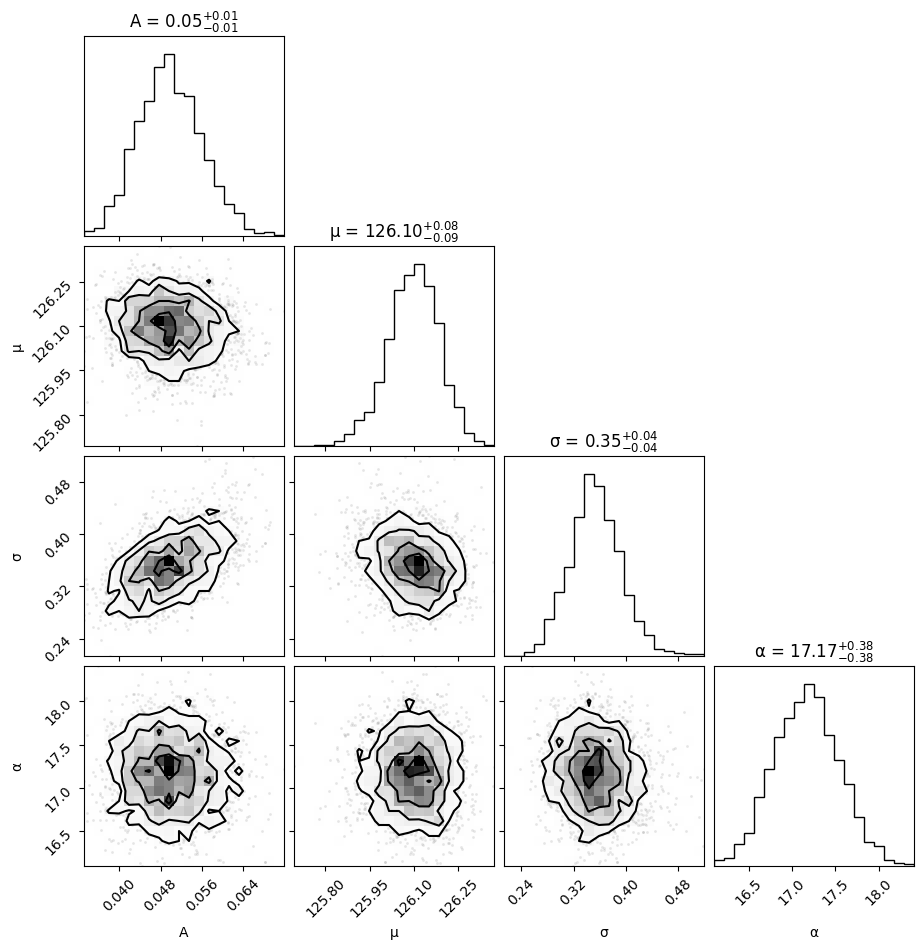

In [16]:
# Configuración inicial para emcee
n_walkers = 32  # Número de caminantes
n_dim = 4  # Dimensión del espacio de parámetros (A, mu, sigma, alpha)
n_steps = 1000  # Número de pasos

    # Generar posiciones iniciales cerca de los valores óptimos
initial_guess = [0.3, 125, 2, 15]  # Valores aproximados iniciales
initial_positions = [
        initial_guess + 1e-4 * np.random.randn(n_dim) for _ in range(n_walkers)
    ]

    # Ejecutar el muestreo MCMC
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(data,))
sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # Extraer cadenas y graficar resultados
samples = sampler.get_chain(discard=200, thin=10, flat=True)

    # Graficar distribuciones marginales
import corner

fig = corner.corner(
        samples,
        labels=["A", "μ", "σ", "α"],
        truths=[0.3, 125, 2, 15],  # Valores iniciales aproximados
        show_titles=True,
)
plt.show()

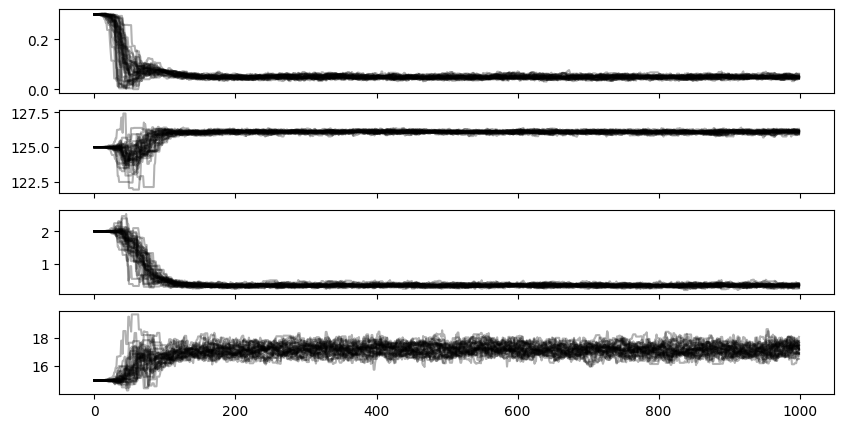

In [17]:
fig, axes = plt.subplots(4, figsize=(10,5), sharex=True)

samples = sampler.get_chain()
labels = ["A", "μ", "σ", "α"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
